In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib
import gc

import lightgbm as lgb
from sklearn import preprocessing
from sklearn import pipeline
from sklearn import impute
from scipy.optimize import minimize
from scipy.stats import beta

import optuna
from optuna.visualization import (
    plot_contour
    , plot_edf
    , plot_intermediate_values
    , plot_optimization_history
    , plot_parallel_coordinate
    , plot_param_importances
    , plot_slice
)

pd.set_option('display.max_columns', None)


import plotly.express as px
import plotly.io as pio
pio.renderers.default = "png"

/home/mavillan/mambaforge/envs/kg/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


***
## loading data

In [2]:
input_path = "../data/raw"

train = pd.read_csv(f"{input_path}/train.csv")
test  = pd.read_csv(f"{input_path}/test.csv")
greeks = pd.read_csv(f"{input_path}/greeks.csv")

train.columns = [col.strip() for col in train.columns]
test.columns = [col.strip() for col in test.columns]

# available features
input_cols = train.columns[1:-1]
categ_cols = ["EJ"]

# we extend train with dummies from greeks
dummies = pd.get_dummies(greeks[["Alpha","Beta","Gamma","Delta"]])
train[dummies.columns] = dummies

# encode of categorical features
encoder = preprocessing.LabelEncoder().fit(train["EJ"])
train["EJ"] = encoder.transform(train["EJ"]).astype(int)
test["EJ"] = encoder.transform(test["EJ"]).astype(int)

display(train)

,Id,AB,AF,AH,AM,AR,AX,AY,AZ,BC,BD,BN,BP,BQ,BR,BZ,CB,CC,CD,CF,CH,CL,CR,CS,CU,CW,DA,DE,DF,DH,DI,DL,DN,DU,DV,DY,EB,EE,EG,EH,EJ,EL,EP,EU,FC,FD,FE,FI,FL,FR,FS,GB,GE,GF,GH,GI,GL,Class,Alpha_A,Alpha_B,Alpha_D,Alpha_G,Beta_A,Beta_B,Beta_C,Gamma_A,Gamma_B,Gamma_E,Gamma_F,Gamma_G,Gamma_H,Gamma_M,Gamma_N,Delta_A,Delta_B,Delta_C,Delta_D
0,000ff2bfdfe9,0.209377,3109.03329,85.200147,22.394407,8.138688,0.699861,0.025578,9.812214,5.555634,4126.58731,22.5984,175.638726,152.707705,823.928241,257.432377,47.223358,0.563481,23.387600,4.851915,0.023482,1.050225,0.069225,13.784111,1.302012,36.205956,69.08340,295.570575,0.238680,0.284232,89.245560,84.31664,29.657104,5.310690,1.74307,23.187704,7.294176,1.987283,1433.166750,0.949104,1,30.879420,78.526968,3.828384,13.394640,10.265073,9028.291921,3.583450,7.298162,1.73855,0.094822,11.339138,72.611063,2003.810319,22.136229,69.834944,0.120343,1,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1
1,007255e47698,0.145282,978.76416,85.200147,36.968889,8.138688,3.632190,0.025578,13.517790,1.229900,5496.92824,19.4205,155.868030,14.754720,51.216883,257.432377,30.284345,0.484710,50.628208,6.085041,0.031442,1.113875,1.117800,28.310953,1.357182,37.476568,70.79836,178.553100,0.238680,0.363489,110.581815,75.74548,37.532000,0.005518,1.74307,17.222328,4.926396,0.858603,1111.287150,0.003042,0,109.125159,95.415086,52.260480,17.175984,0.296850,6785.003474,10.358927,0.173229,0.49706,0.568932,9.292698,72.611063,27981.562750,29.135430,32.131996,21.978000,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0
2,013f2bd269f5,0.470030,2635.10654,85.200147,32.360553,8.138688,6.732840,0.025578,12.824570,1.229900,5135.78024,26.4825,128.988531,219.320160,482.141594,257.432377,32.563713,0.495852,85.955376,5.376488,0.036218,1.050225,0.700350,39.364743,1.009611,21.459644,70.81970,321.426625,0.238680,0.210441,120.056438,65.46984,28.053464,1.289739,1.74307,36.861352,7.813674,8.146651,1494.076488,0.377208,1,109.125159,78.526968,5.390628,224.207424,8.745201,8338.906181,11.626917,7.709560,0.97556,1.198821,37.077772,88.609437,13676.957810,28.022851,35.192676,0.196941,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0
3,043ac50845d5,0.252107,3819.65177,120.201618,77.112203,8.138688,3.685344,0.025578,11.053708,1.229900,4169.67738,23.6577,237.282264,11.050410,661.518640,257.432377,15.201914,0.717882,88.159360,2.347652,0.029054,1.400300,0.636075,41.116960,0.722727,21.530392,47.27586,196.607985,0.238680,0.292431,139.824570,71.57120,24.354856,2.655345,1.74307,52.003884,7.386060,3.813326,15691.552180,0.614484,1,31.674357,78.526968,31.323372,59.301984,7.884336,10965.766040,14.852022,6.122162,0.49706,0.284466,18.529584,82.416803,2094.262452,39.948656,90.493248,0.155829,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0
4,044fb8a146ec,0.380297,3733.04844,85.200147,14.103738,8.138688,3.942255,0.054810,3.396778,102.151980,5728.73412,24.0108,324.546318,149.717165,6074.859475,257.432377,82.213495,0.536467,72.644264,30.537722,0.025472,1.050225,0.693150,31.724726,0.827550,34.415360,74.06532,200.178160,0.238680,0.207708,97.920120,52.83888,26.019912,1.144902,1.74307,9.064856,7.350720,3.490846,1403.656300,0.164268,1,109.125159,91.994825,51.141336,29.102640,4.274640,16198.049590,13.666727,8.153058,48.50134,0.121914,16.408728,146.109943,8524.370502,45.381316,36.262628,0.096614,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
612,fd3dafe738fd,0.149555,3130.05946,123.763599,9.513984,13.020852,3.499305,0.077343,8.545512,2.804172,4157.68439,21.1860,167.877117,27.287375,365.516874,257.432377,41.368691,0.691257,55.163024,4.780452,0.013930,1.177525,0.698250,40.159779,1.070298,7.030640,21.75904,355.930925,0.238680,0.445479,176.977590,90.91832,27.957928,0.005518,2.41906,32.508604,8.015112,1.354416,495.086300,0.003042,0,51.

In [3]:
preproc_pipe = pipeline.Pipeline([
    ("imputer", impute.SimpleImputer(strategy="median")), 
    ("scaler", preprocessing.MaxAbsScaler()),
])

preproc_pipe.fit(train[input_cols])
display(preproc_pipe)

train[input_cols] = preproc_pipe.transform(train[input_cols])
test[input_cols] = preproc_pipe.transform(test[input_cols])

Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('scaler', MaxAbsScaler())])

In [4]:
repeated_cv_split = joblib.load("../data/iarc-data-split/repeated_5fold_cv_split_4tuning.pkl")
print(len(repeated_cv_split))

# number of repetitions to use
REPETITIONS = 10

10


***
## training

In [5]:
def balanced_logloss_(y_pred, y_true):
    n0 = np.sum(1-y_true)
    n1 = np.sum(y_true)
    p1 = np.clip(y_pred, 1e-15, 1-1e-15)
    p0 = 1-p1
    log_loss0 = - np.sum((1-y_true) * np.log(p0)) / n0
    log_loss1 = - np.sum(y_true * np.log(p1)) / n1
    return (log_loss0 + log_loss1)/2

def balanced_logloss(y_pred: np.ndarray, data: lgb.Dataset):
    y_true = data.get_label()
    return 'balanced_logloss', balanced_logloss_(y_pred, y_true), False 

In [6]:
pct = train.Class.value_counts(normalize=True)
scale_pos_weight = pct[0]/pct[1]
print("scale_pos_weight:", scale_pos_weight)

cnt = train.Class.value_counts(normalize=False)
neg_bagging_fraction = cnt[1]/cnt[0]
print("neg_bagging_fraction:", neg_bagging_fraction)

scale_pos_weight: 4.712962962962963
neg_bagging_fraction: 0.21218074656188604


In [7]:
#balance_method = "weight"
balance_method = "bagging"

DEFAULT_PARAMS = {
    'objective': 'binary',
    'metric': 'None',
    'learning_rate': 0.005,
    'bagging_freq': 1,
    'seed': 2112,
    'first_metric_only': False,
    'feature_pre_filter': False,
    'verbosity': -1,

    'linear_tree':True,
    #'boosting':'dart',

    #'max_bin': 63,
    #'num_leaves': 7,
    
    #'pos_bagging_fraction': 1,
    #'neg_bagging_fraction': 0.21218074656188604,
    
    #'feature_fraction': 0.75,
    #'lambda_l1': 0.00020196676966216634,
    #'lambda_l2': 2.3627262174517976e-09,
    #'min_data_in_leaf': 13,
    #'min_gain_to_split': 0.0007626326850799573,
    #'num_iterations': 1591,
    #'path_smooth': 2.652521741711401e-09,
}

if balance_method == "weight":
    DEFAULT_PARAMS["scale_pos_weight"] = scale_pos_weight
elif balance_method == "bagging":
    DEFAULT_PARAMS["bagging_freq"] = 1
    DEFAULT_PARAMS["pos_bagging_fraction"] = 1
    DEFAULT_PARAMS["neg_bagging_fraction"] = neg_bagging_fraction
else:
    print("Unknown balance_method")
    
display(DEFAULT_PARAMS)

{'objective': 'binary',
 'metric': 'None',
 'learning_rate': 0.005,
 'bagging_freq': 1,
 'seed': 2112,
 'first_metric_only': False,
 'feature_pre_filter': False,
 'verbosity': -1,
 'linear_tree': True,
 'pos_bagging_fraction': 1,
 'neg_bagging_fraction': 0.21218074656188604}

In [8]:
def train_validate(
        dataframe,
        input_cols, 
        model_params,
        repeated_cv_split,
        n_repetitions=REPETITIONS,
        verbose=False,
    ):

    metrics = list()
    model_params = dict(model_params)
    num_iterations = (
        2000 if "num_iterations" not in model_params.keys() 
        else model_params.pop("num_iterations")
    )

    for repeat in range(n_repetitions):
        if verbose:
            print(f"REPEAT NUMBER: {repeat+1}/{n_repetitions}")
        cv_split = repeated_cv_split[f"repeat_{repeat}"]
        n_folds = len(cv_split)
        
        for split in cv_split:
            fold = split["fold"]
            train_idx = split["train_idx"]
            valid_idx = split["valid_idx"]
            if verbose:
                print(f"training model for fold: {fold+1}/{n_folds}")
        
            train_df = dataframe.loc[train_idx,:].reset_index(drop=True)
            valid_df = dataframe.loc[valid_idx,:].reset_index(drop=True)

            train_dset = lgb.Dataset(
                data=train_df.loc[:,input_cols],
                label=train_df.loc[:,"Class"].values,
                free_raw_data=False
            )
            model = lgb.train(
                params=model_params,
                train_set=train_dset,
                num_boost_round=num_iterations,
            )
            
            if verbose:
                lgb.plot_importance(model, importance_type="gain", figsize=(8,15))
                plt.show()
                lgb.plot_importance(model, importance_type="split", figsize=(8,15))
                plt.show()

            y_pred = model.predict(valid_df.loc[:,input_cols])
            metrics.append( balanced_logloss_(y_pred, valid_df.loc[:,"Class"].values) )
    
    return np.mean(metrics), np.std(metrics)


def objective(trial):
    sampled_params = dict(
        # general booster config
        max_bin = 2**trial.suggest_int("max_bin_exp", 4, 8) - 1,
        num_leaves = 2**trial.suggest_int("num_leaves_exp", 2, 6) - 1,
        num_iterations = trial.suggest_int("num_iterations", 100, 3000),
        # regularization
        feature_fraction = trial.suggest_float("feature_fraction", 0.5, 1.0, step=0.05),
        #bagging_fraction = trial.suggest_float("bagging_fraction", 0.8, 1.0, step=0.01),
        min_data_in_leaf = trial.suggest_int("min_data_in_leaf", 5, 100),
        
        #lambda_l1 = trial.suggest_float("lambda_l1", 1e-10, 1e1, log=True),
        lambda_l2 = trial.suggest_float("lambda_l2", 1e-10, 1e1, log=True),
        path_smooth = trial.suggest_float("path_smooth", 1e-10, 1e1, log=True),
        min_gain_to_split = trial.suggest_float("min_gain_to_split", 1e-10, 1e1, log=True),
        max_delta_step = trial.suggest_float("max_delta_step", 1e-10, 1e1, log=True),

        # linear tree regularization parameter
        linear_lambda = trial.suggest_float("linear_lambda", 1e-10, 1e1, log=True),

        sigmoid = trial.suggest_float("sigmoid", 0.1, 10,),
        boost_from_average = trial.suggest_categorical("boost_from_average", [True, False]),
        
        # dart
        #drop_rate = trial.suggest_float("drop_rate", 0.05, 0.3, step=0.01),
        #max_drop = trial.suggest_int("max_drop", 10, 100, 5),
        #skip_drop = trial.suggest_float("skip_drop", 0.2, 0.8, step=0.05),
    )
    model_params = {**DEFAULT_PARAMS, **sampled_params}
    
    metric_mean, metric_std = train_validate(
        dataframe = train,
        input_cols = input_cols,
        model_params = model_params,
        repeated_cv_split = repeated_cv_split,
        n_repetitions = REPETITIONS,
        verbose = False,
    )
    
    return metric_mean

In [9]:
%%time

train_validate(
    dataframe = train,
    input_cols = input_cols,
    model_params = DEFAULT_PARAMS,
    repeated_cv_split = repeated_cv_split,
    n_repetitions = REPETITIONS,
    verbose = False
    
)

CPU times: user 7min 6s, sys: 6.95 s, total: 7min 13s
Wall time: 56.5 s


(0.29030632377487836, 0.15746220638484598)

In [10]:
do_optimize = True

study = optuna.create_study(
    study_name="iarc-lgbm-linear-bagging-balanced",
    direction='minimize',
    storage='sqlite:///iarc-lgbm-linear-bagging-balanced.db',
    load_if_exists=True,
)

if do_optimize:
    study.optimize(
        objective, 
        n_trials=10_000, 
        timeout=43200, # 12 hours
        n_jobs=1, 
        gc_after_trial=True,
    ) 

[I 2023-07-08 07:01:28,811] Using an existing study with name 'iarc-lgbm-linear-bagging-balanced' instead of creating a new one.
[I 2023-07-08 07:01:54,100] Trial 4 finished with value: 0.967587658561922 and parameters: {'boost_from_average': True, 'feature_fraction': 0.5, 'lambda_l2': 0.09185815474389933, 'linear_lambda': 1.2006028947309536e-10, 'max_bin_exp': 4, 'max_delta_step': 2.4419606741525664e-07, 'min_data_in_leaf': 45, 'min_gain_to_split': 5.737479959573637, 'num_iterations': 2412, 'num_leaves_exp': 6, 'path_smooth': 1.5494233285287427e-07, 'sigmoid': 9.944357618656571}. Best is trial 0 with value: 0.3117734059476168.
[I 2023-07-08 07:02:17,500] Trial 5 finished with value: 0.967587744821804 and parameters: {'boost_from_average': True, 'feature_fraction': 0.6, 'lambda_l2': 0.1592501787210557, 'linear_lambda': 0.002508830520798096, 'max_bin_exp': 7, 'max_delta_step': 1.5367383403493307e-05, 'min_data_in_leaf': 32, 'min_gain_to_split': 0.10824334522057517, 'num_iterations': 217

In [11]:
study.trials_dataframe().sort_values("value", ascending=True).head(20)

,number,value,datetime_start,datetime_complete,duration,params_boost_from_average,params_feature_fraction,params_lambda_l2,params_linear_lambda,params_max_bin_exp,params_max_delta_step,params_min_data_in_leaf,params_min_gain_to_split,params_num_iterations,params_num_leaves_exp,params_path_smooth,params_sigmoid,state
1114,1114,0.230801,2023-07-08 17:53:29.620001,2023-07-08 17:54:06.044190,0 days 00:00:36.424189,True,0.95,9.915566e-02,0.000008,5,3.842219,18,0.000024,1362,5,0.000098,1.159545,COMPLETE
1112,1112,0.231076,2023-07-08 17:52:11.396563,2023-07-08 17:52:48.498945,0 days 00:00:37.102382,True,0.95,6.011318e-02,0.000006,5,3.670552,18,0.000032,1382,5,0.000059,1.797889,COMPLETE
1191,1191,0.231142,2023-07-08 18:27:47.961268,2023-07-08 18:28:22.538445,0 days 00:00:34.577177,True,1.00,2.283788e-01,0.000006,5,1.107491,19,0.154289,1369,5,0.009407,2.674335,COMPLETE
769,769,0.231190,2023-07-08 15:09:15.545529,2023-07-08 15:09:52.307838,0 days 00:00:36.762309,True,0.95,1.555775e-01,0.000018,5,1.634355,19,0.004068,1416,5,0.005802,2.283447,COMPLETE
777,777,0.231318,2023-07-08 15:13:42.402031,2023-07-08 15:14:19.659149,0 days 00:00:37.257118,True,0.95,1.025525e-01,0.000022,5,1.909749,18,0.005769,1387,5,0.009928,2.162195,COMPLETE
691,691,0.231547,2023-07-08 14:33:12.702849,2023-07-08 14:33:50.593612,0 days 00:00:37.890763,True,0.95,6.778719e-01,0.000007,5,9.917676,19,0.001592,1498,5,0.000018,1.906915,COMPLETE
640,640,0.231594,2023-07-08 14:10:01.634848,2023-07-08 14:10:38.890855,0 days 00:00:37.256007,True,0.95,6.102418e-10,0.000010,5,6.199840,20,0.088247,1505,5,0.000011,2.969858,COMPLETE
761,761,0.231629,2023-07-08 15:05:28.549943,2023-07-08 15:06:04.005344,0 days 00:00:35.455401,True,0.95,7.189964e-03,0.000011,5,1.079921,20,0.004886,1391,5,0.036938,2.746098,COMPLETE
642,642,0.231689,2023-07-08 14:11:16.385850,2023-07-08 14:11:50.859786,0 days 00:00:34.473936,True,0.95,5.769384e-10,0.000010,5,3.952538,20,0.000060,1360,5,0.000026,2.647115,COMPLETE
695,695,0.231800,2023-07-08 14:35:15.174265,2023-07-08 14:35:52.368683,0 days 00:00:37.194418,True,0.95,1.153022e-01,0.000023,5,3.798952,18,0.000182,1400,5,0.000061,1.838871,COMPLETE


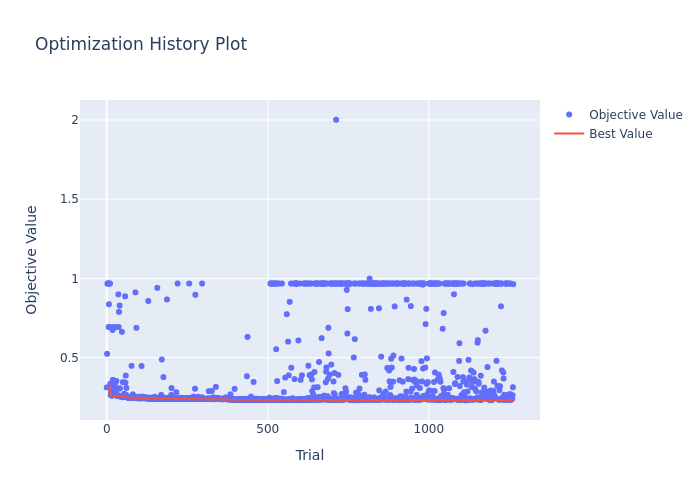

In [12]:
plot_optimization_history(study)

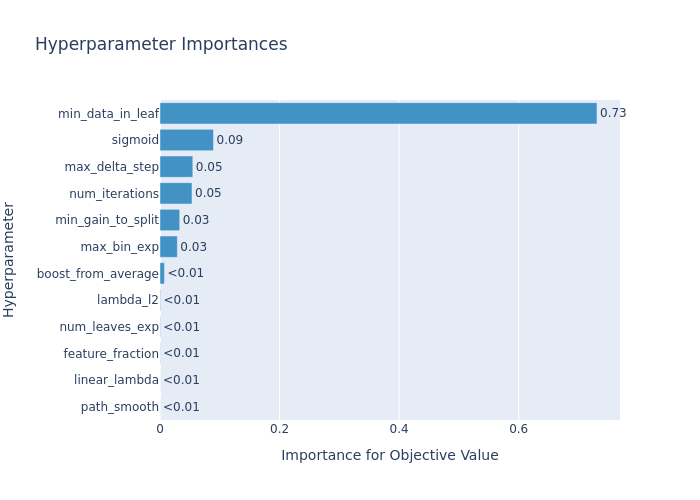

In [13]:
plot_param_importances(study)

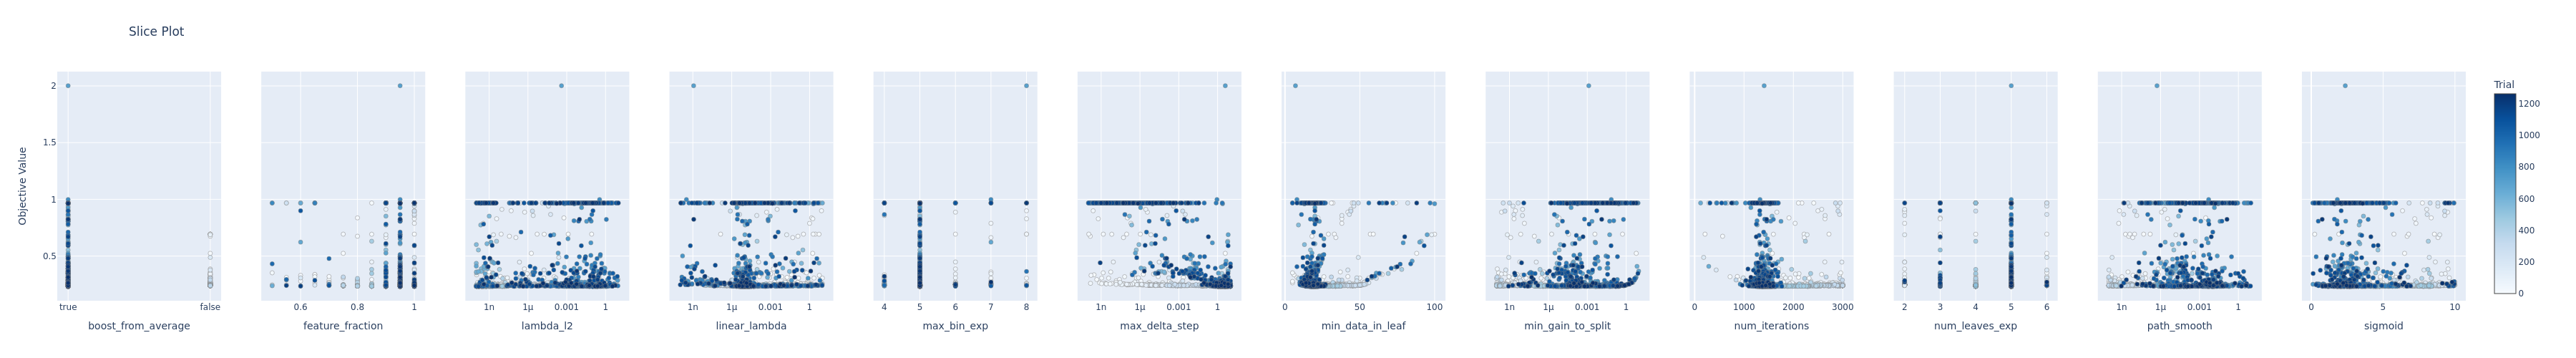

In [14]:
plot_slice(study)

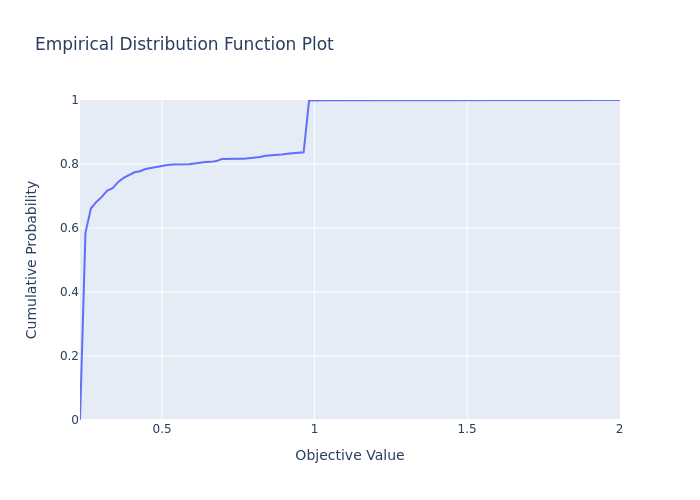

In [15]:
plot_edf(study)

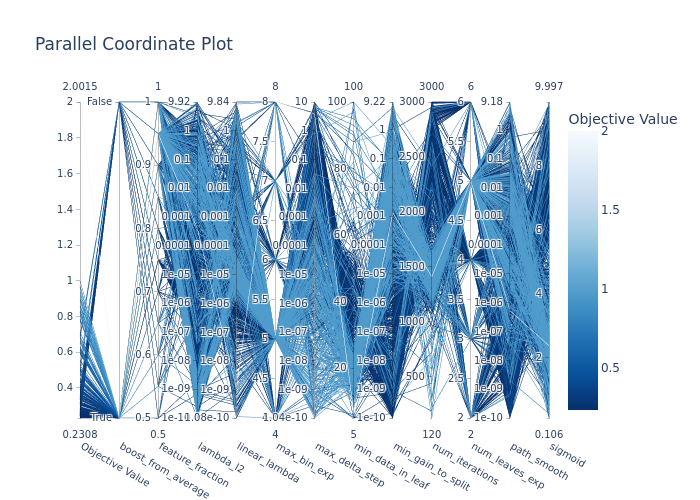

In [16]:
plot_parallel_coordinate(study)

In [17]:
best_params = dict(study.best_params)
best_params["max_bin"] = 2**best_params.pop("max_bin_exp")-1
best_params["num_leaves"] = 2**best_params.pop("num_leaves_exp")-1
best_params = {**DEFAULT_PARAMS, **best_params}
best_params

{'objective': 'binary',
 'metric': 'None',
 'learning_rate': 0.005,
 'bagging_freq': 1,
 'seed': 2112,
 'first_metric_only': False,
 'feature_pre_filter': False,
 'verbosity': -1,
 'linear_tree': True,
 'pos_bagging_fraction': 1,
 'neg_bagging_fraction': 0.21218074656188604,
 'boost_from_average': True,
 'feature_fraction': 0.95,
 'lambda_l2': 0.09915566037214062,
 'linear_lambda': 7.827595924024919e-06,
 'max_delta_step': 3.8422190490701893,
 'min_data_in_leaf': 18,
 'min_gain_to_split': 2.4132946413716756e-05,
 'num_iterations': 1362,
 'path_smooth': 9.81451747284295e-05,
 'sigmoid': 1.1595448578213623,
 'max_bin': 31,
 'num_leaves': 31}

***